<a target="_blank" href="https://colab.research.google.com/github/eldanc/mlbootcamp2024/blob/main/lab_4_2_interpretability.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# UofT DSI-CARTE ML Bootcamp
#### June 13, 2024
#### Interpretability and Fairness - Lab 2, Day 4
#### Teaching team: Eldan Cohen, Nakul Upadhya, Hriday Chedda
##### Lab author: Nakul Upadhya modified by Eldan Cohen and Alex Olson

As decision-making increasingly relies on artificial intelligence, the issue of fairness and equity in machine learning is rapidly becoming a larger concern. In this lab, we will introduce various metrics that help analyze the biases of our models, as well as techniques that can help mitigate these discrepancies.

The main packages we will be using in this lab is `fairlearn` [1], `interpret`[5], and `shap` [4] along with all the other packages we have previously used.



In [ ]:
## Install Packages
!pip install fairlearn
!pip install shap
!pip install xgboost
!pip install interpret

## Import packages
import numpy as np
import pandas as pd

# IGNORE THESE LINES. They just turn off some annoying messages
pd.options.mode.chained_assignment = None
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

## Data
For this analysis, we will be working with the COMPAS dataset [2], a dataset used by the Correctional Offender Management Profiling for Alternative Sanctions (COMPAS) system. This is a popular tool used in the United States to assess the risk of recidivism (likelihood of re-offending) for individuals involved in the criminal justice system. ***The system is currently actively employed by judges and parole boards to make decisions about bail, sentencing, and parole.***

The COMPAS system has been criticized for exhibiting racial and gender biases. Many studies have suggested that the tool is more likely to label Black defendants as high-risk and White defendants as low-risk, even when controlling for other factors. This has raised concerns about fairness and potential discrimination in decision-making processes. For more information about COMPAS, I highly encourage reading the [Propublica article that broke the story](https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing).

This highly controversial system and the data it uses perfectly demonstrates the need for interpretability in machine learning. Let's start by reading and preprocessing the data. Some of the code for preprocessing has been borrowed from [this notebook.](https://github.com/tsotne95/FairnessCompas/blob/master/Fairness_in_Classification_on_the_COMPAS_dataset.ipynb)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Load data
df_original = pd.read_csv(
    "https://raw.githubusercontent.com/tsotne95/FairnessCompas/master/compas-scores-two-years.csv"
)
print(f"Original Entries in dataset: {df_original.shape}")

# Preprocessing
df_clean = df_original.dropna(
    subset=["days_b_screening_arrest"]
)  # dropping missing vals
df_clean = df_clean[
    (df_clean.days_b_screening_arrest <= 30)
    & (df_clean.days_b_screening_arrest >= -30)
    & (df_clean.is_recid != -1)
    & (df_clean.c_charge_degree != "O")
    & (df_clean.score_text != "N/A")
]

# Reset index after removing rows
df_clean.reset_index(inplace=True, drop=True)

# Keep relevant columns and rename
df_clean = df_clean[
    [
        "sex",
        "age",
        "race",
        "juv_fel_count",
        "juv_misd_count",
        "juv_other_count",
        "priors_count",
        "two_year_recid",
        "c_charge_degree",
    ]
]
df_clean.rename({"c_charge_degree": "felony"}, axis=1, inplace=True)

# Label encoding for 'sex' and 'felony' columns
label_encoder = LabelEncoder()
df_clean["sex"] = label_encoder.fit_transform(df_clean["sex"])
df_clean["felony"] = label_encoder.fit_transform(df_clean["felony"])

# Get dummies for 'race' column
df_dummies = pd.get_dummies(df_clean["race"])
df_dummies.columns = [x for x in df_dummies.columns]

# Drop 'race' column and concatenate the dummies dataframe
df_final = pd.concat([df_clean.drop("race", axis=1), df_dummies], axis=1)

# Remove NA values
df_final = df_final.dropna()
print(f"Entries in dataset after preprocessing: {df_final.shape}")

# Define features and target
X = df_final.drop("two_year_recid", axis=1)
y = df_final["two_year_recid"]


Original Entries in dataset: (7214, 53)
Entries in dataset after preprocessing: (6172, 14)


Now that its been pre-processed, lets split it up into train and test datasets.

In [ ]:

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

# Print final dataset information
print(
    f"There are {X_train.shape[0]} training data points and {X_test.shape[0]} testing points"
)
print(f"There are {X_train.shape[1]} features in the dataset")

There are 4629 training data points and 1543 testing points
There are 13 features in the dataset


## Model-Based Interpretability

One way we can use machine learning is to explore potential systemic issues present in the data. One way to do this is to utilize models that are constrained so that their predictive mechanisms are innately understandable to humans.

### Decision Tree
One approach that provides model-based interpretability is the Decision Tree. Once a decision tree is trained, we as humans can visualize and walk through its decision mechanisms.

Lets try fitting a 3 layer decision tree on our model and print out the testing accuracy and what features are used.



In [ ]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import accuracy_score
import graphviz # Package containing visualization tools

tree_clf = DecisionTreeClassifier(max_depth = 3, random_state = 42)

tree_clf.fit(X_train, y_train)

accuracy = accuracy_score(y_test, tree_clf.predict(X_test)) * 100
print(f"Test Accuracy: {accuracy :.2f}%")

Test Accuracy: 67.47%


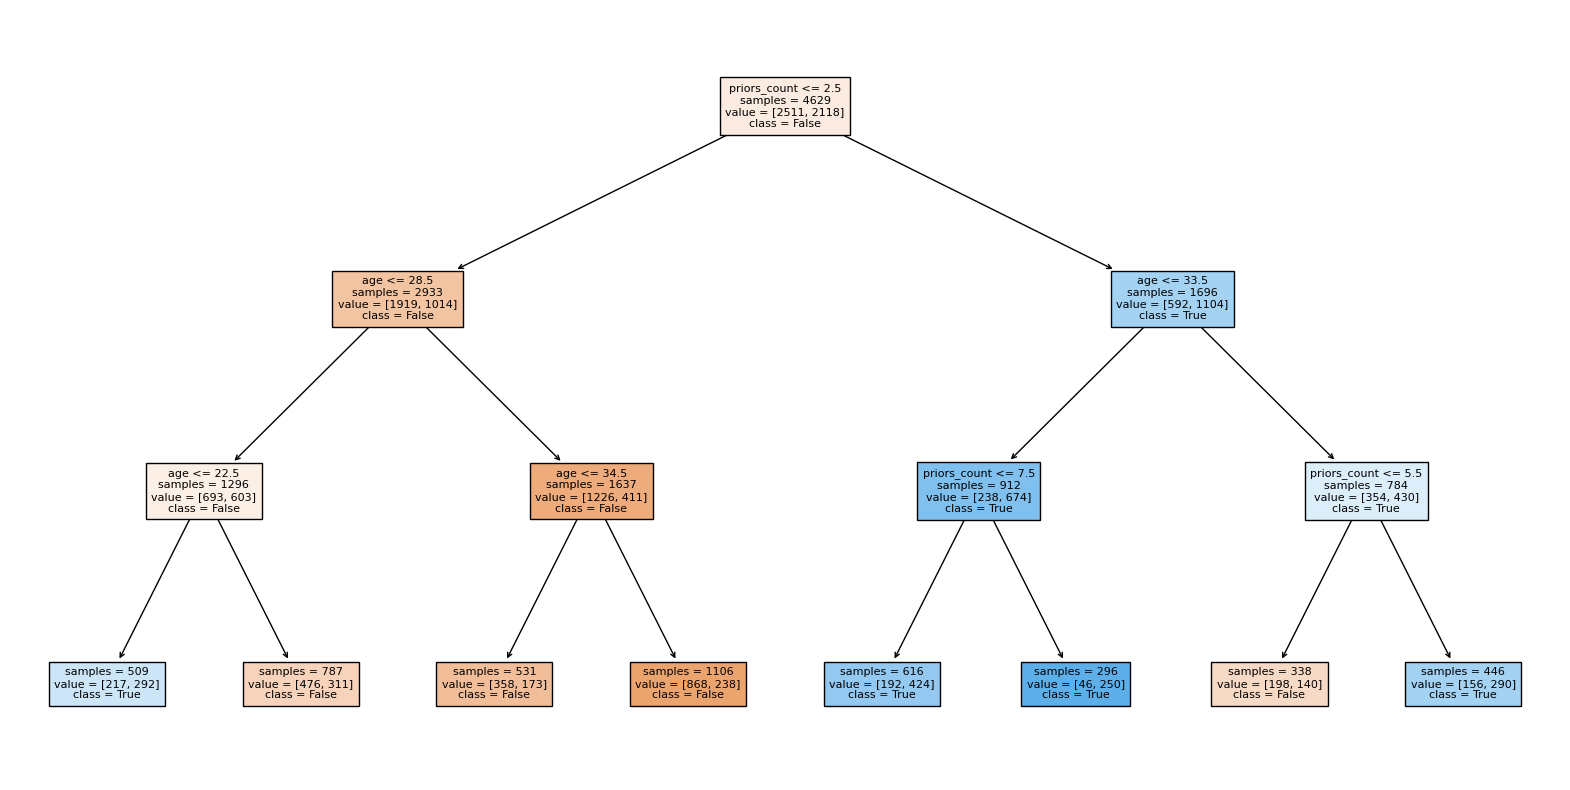

In [ ]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

def plot_decision_tree(
    clf, feature_names, class_names=["False", "True"], figsize=(20, 10), fontsize=8
):
    fig, ax = plt.subplots(figsize=figsize)
    plot_tree(
        clf,
        feature_names=feature_names,
        filled=True,
        ax=ax,
        impurity=False,
        class_names=class_names,
        fontsize=fontsize,
    )
    plt.show()


# usage
plot_decision_tree(tree_clf, X_test.columns)

## This tree is shaded based on the number of data points that fall into that node
## and the label of those datapoints. Ex. A dark blue node means that most of
## training datapoints that fall into that node did commit a crime within
## two years of release. Dark orange is the opposite.

In [ ]:
import plotly.express as px # Interactive Plotting Package

tree_importances = pd.DataFrame()
tree_importances['feature'] = X_train.columns
tree_importances['tree_importance'] = tree_clf.feature_importances_
tree_importances.sort_values(by = 'tree_importance', inplace =True, ascending = False)
# Remove features without any importance
importances = tree_importances[tree_importances['tree_importance'] > 0]
px.bar(importances, x = 'feature', y = 'tree_importance')

### Generalized Additive Models

In many cases, the decision tree is not the ideal model and we may want to utilize alternatives. One potential alternative approach is the **Generalized Additive Model (GAM).**

GAMs are inherently interpretable models that learn a shape function for each feature, and predictions are made by “querying” the shape function. Since these shape functions are independent, the impact of a feature on the prediction can be understood by visualizing these shape functions, making them highly explainable. Formally, a GAM's prediction ($g(x)$) is defined as:
$$
g(x) = \sum_{i=1}^N f(x_i)
$$

Lets train and visualize a GAM to see how this looks like. The GAM we will use today is the *Explainable Boosting Machine* (EBM) available in the `interpret` package. First lets fit the EBM:


In [ ]:
from interpret.glassbox import ExplainableBoostingClassifier

gam_clf = ExplainableBoostingClassifier(interactions = 0, random_state = 42)

gam_clf.fit(X_train, y_train)

accuracy = accuracy_score(y_test, gam_clf.predict(X_test)) * 100
print(f"Test Accuracy: {accuracy :.2f}%")

Test Accuracy: 67.40%


The `interpret` package provides the ability to visualize the feature importances of the GAM as well as the learned shape functions. You can navigate the different graphs using the dropdown.

In [ ]:
from interpret import show

ebm_global = gam_clf.explain_global()
show(ebm_global)


**Your Turn:**
*   What is most important features?
*   Do these importances line up with the decision tree explanations above?
*   For the most important features, can you describe the relationship between the feature and the model prediction?


GAMs can also be extended to GA$^2$Ms, where we can model the pairwise interaction between various features. Formally, a GA2M's prediction ($g(x)$) is defined as:
$$
g(x) = \sum_{i=1}^N f_i(x_i) + \sum_{i=1}^{N} \sum_{j>i}^N f_{i,j}(x_i,x_j)
$$

Lets train a GA$^2$M with 5 possible interactions:

In [ ]:
from interpret.glassbox import ExplainableBoostingClassifier

ga2m_clf = ExplainableBoostingClassifier(interactions = 5, random_state = 42)

ga2m_clf.fit(X_train, y_train)

accuracy = accuracy_score(y_test, ga2m_clf.predict(X_test)) * 100
print(f"Test Accuracy: {accuracy :.2f}%")

Test Accuracy: 67.66%


The impact of a pairwise interaction can be visualized via a heatmap and can be displayed using the same code as before. In the feature importance plot, the interaction is displayed as `feature 1 & feature 2`.  

In [ ]:
from interpret import show

ebm_global = ga2m_clf.explain_global()
show(ebm_global)

## Post-Hoc Interpretability

Not all models can provide intrinsic explanations. One example of this is SVM where it simply creates hyperplanes to seperate classes. So what do we do in this case? This is where *post-hoc interpretability* methods come into play. Post-hoc methods work y taking in a trained models, modifying the inputs, and examining how significantly the outputs changed.

One such interpretability tool is SHAP (Shapely Additive Values). SHAP provides feature importance by using methods from game theory to estimate the contribution of each feature towards the final prediction.


SHAP can provide a sense of both local (explaining a single prediction) and global (explaining general prediction trends) interpretability.

To start, we first need to train a model to explain. For this exercise, we will use SVM with a radial kernel

In [ ]:
from sklearn.svm import SVC

svc_clf = SVC(kernel = 'rbf', max_iter = 2000)
svc_clf.fit(X_train, y_train)
accuracy = accuracy_score(y_test, svc_clf.predict(X_test)) * 100
print(f"Test Accuracy: {accuracy :.2f}%")

Test Accuracy: 68.83%


Now to start our explanation process. We start off by first creating a summary of our dataset (this is to make SHAP run faster) and creating our explainer object.





In [ ]:
import shap
# rather than use the whole training set to estimate expected values, we summarize with
# a set of weighted kmeans, each weighted by the number of points they represent.
# this helps everything run faster
X_train_summary = shap.kmeans(X_train, 7)

# Create the shap explainer by passing in our model's predict function and
# the summarized training set
ex = shap.KernelExplainer(svc_clf.predict, X_train_summary, feature_names = X_train.columns)

# We are also only going to look at 100 points (to make it easier to visualize)
X_test_subset = X_test.sample(100, random_state = 42).reset_index(drop=True)


Let's first look into the local explainability provided by SHAP by examining what contributes to the predictions of the first datapoint in our testing subset.

In [ ]:
shap.initjs()
first_datapoint = X_test_subset.iloc[0]
single_point_shap_values = ex.shap_values(first_datapoint)
shap.force_plot(ex.expected_value, single_point_shap_values, X_test_subset.iloc[0])

In the plot above, feature values that increased the chance of the model predicting a readmission are in red and have arrows that point to the right (they provide a positive force) and feature values that detract from the probability of readmission are in blue and point to the left. The larger the arrow, the larger the contribution.

**Your Turn**

* What features seem to have the most negative impact to the end prediction of the data point you chose? What about the one with the most positive impact? *YOUR ANSWER HERE*
* Choose a different data point and see if you see any similarities in the features used and their impact towards the end prediction. *YOUR ANSWER HERE*


#### Global Explanability
We can get a sense of global interpretability from SHAP by examining trends in the SHAP values across the variable values. To do this, we can generate a summary plot of the calculated values. NOTE: This may take a while.....

  0%|          | 0/100 [00:00<?, ?it/s]

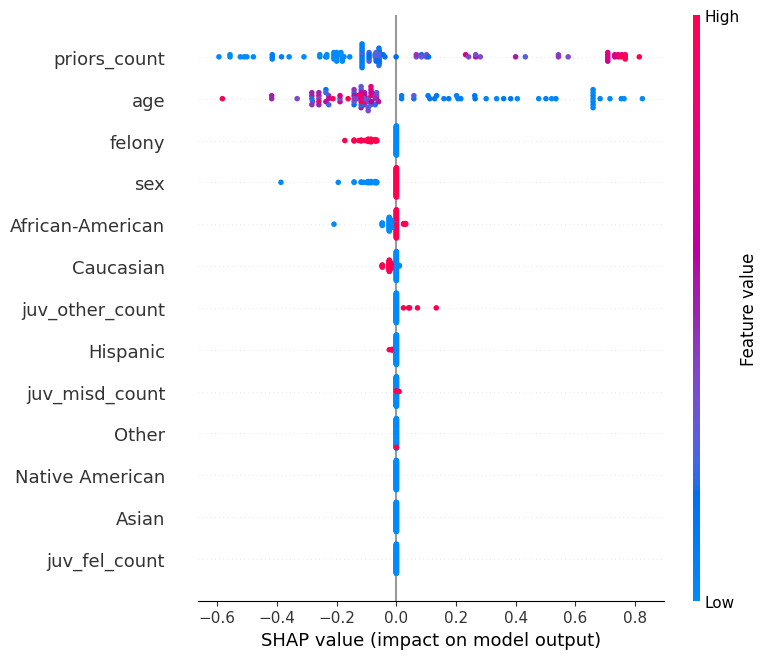

In [ ]:
shap.initjs()
shap_values = ex.shap_values(X_test_subset)
shap.summary_plot(shap_values, X_test_subset)

The color of the point reflects the value of a given feature in a given data point. For example, a red point in `felony` means that the feature took a value of 1 (true) and a blue point means a value of 0 (false). The X-axis of this plot represents SHAP contribution (the estimated impact on the end model prediction). By examining the distribution of the feature values across the x-axis, we can find what features may

In [ ]:
abs_shap_values = np.abs(shap_values)
shap_sums = np.sum(abs_shap_values, axis=0)
importances = pd.DataFrame()
importances['feature'] = X_train.columns
importances['importance'] = shap_sums
importances.sort_values(by = 'importance', inplace =True, ascending = False)
importances = importances[importances['importance'] > 0]
px.bar(importances, x = 'feature', y = 'importance')

**Your Turn**

* What features seem important to the SVM model according to SHAP? *YOUR ANSWER HERE*
* Do these SHAP importances align with the EBM and Decision Tree Importances? *YOUR ANSWER HERE

Now consider all three models and the feature importances found.
* Are there any pattern that make sense to you? *YOUR ANSWER HERE*
* Are there any patterns that seem concerning from an equity perspective? *YOUR ANSWER HERE*

#### Notes about SHAP
SHAP is an incredibly powerful tool to understand what your model may be doing, ***however it is only an estimate***. The SHAP value calculations only examine your model's behavior and do not dive into the internals of the model, therefore these values should not be taken at face value. Additionally, as you may have noticed in the plots above, SHAP values do not reflect interacting effects between features, something that most models do in fact use. This extends to other post-hoc interpretability methods as well.

As such, it is highly encouraged to use innately interpretable models whenever possible. For a more rigourous justification, please read Cynthia Rudin's paper on the subject [3] after the lab.

Additionally, quoting the SHAP documentation [4]:


> Predictive machine learning models like XGBoost become even more powerful when paired with interpretability tools like SHAP. These tools identify the most informative relationships between the input features and the predicted outcome, which is useful for explaining what the model is doing, getting stakeholder buy-in, and diagnosing potential problems. It is tempting to take this analysis one step further and assume that interpretation tools can also identify what features decision makers should manipulate if they want to change outcomes in the future. However, in [this article](https://shap.readthedocs.io/en/latest/example_notebooks/overviews/Be%20careful%20when%20interpreting%20predictive%20models%20in%20search%20of%20causal%C2%A0insights.html), we discuss how using predictive models to guide this kind of policy choice can often be misleading.

> *Eleanor Dillon, Jacob LaRiviere, Scott Lundberg, Jonathan Roth, and Vasilis Syrgkanis from Microsoft.*









## Fairness
Now that we have understood a bit of what are model is looking at and in general how it handles the features, lets examine how fair and equitable our models performance is. Ideally, a fair model should perform identically across different sensitive identities.

Lets examine the fairness of our Decision Tree predictions




In [ ]:
y_pred = tree_clf.predict(X_test) # Save the Test Predictions

#### Measurement
The first step in ML fairness is to measure how fair the model is. For this, we will introduce two metrics.

The first measure is *Demographic Parity*, or more accurately, the distance from demographic parity. Demographic parity is achieved when the probability of a certain prediction is not dependent on a point being in a sensitive group. This metric takes a range between 0 and 1 where 0 means we have achieved perfect demographic parity with respect to that feature.

In general, a parity of under 20% is acceptable in many countries like the United States [1] to avoid legal problems, **however this should not be the goal as "legally acceptable" is not equal to "fair"**, especially in a high-stakes application such as law (like the dataset we are working with). Read more about the 4/5ths fallacy in the [fairlearn documentation](https://fairlearn.org/v0.8/user_guide/assessment/common_fairness_metrics.html#the-four-fifths-rule-often-misapplied) [1] after the lab.

**Your Turn**
* For this problem in particular, what do you think an acceptable parity difference would be? *YOUR ANSWER HERE*
* Run the cell below that evaluates the difference between African-American individuals and non-African-American individuals. Is this model fair with regards to this feature? *YOUR ANSWER HERE*
* Test your own sensitive feature by changing `feature_under_examination`.Try a few features to see if you can find one that exceeds the margin you decided. Were you able to find one? *YOUR ANSWER HERE*

Tip: Get all features in our data used by running `X_test.columns`.

In [ ]:
from fairlearn.metrics import demographic_parity_difference
feature_under_examination = 'African-American'
parity_difference = demographic_parity_difference(y_test,
                                    y_pred,
                                    sensitive_features=X_test[feature_under_examination])
parity_difference = np.round(parity_difference * 100, 3)
print(f"The demographic parity difference for {feature_under_examination} is {parity_difference}%")

The demographic parity difference for African-American is 18.088%


The next metric is Equalized Odds. If equalized odds are achieved, that means that the difference in true positive rates and true negative rates across classes is the same. Often times, we measure the maximum difference between these metrics across the classes. For example, if the TPR and TNR for men were 75% and 65% and the rates for women were 73% and 52%, we would report back 13%.

Similar to demographic parity, we want this to be as low as possible. Additionally, this metric is also subject to the 4/5ths fallacy as well.

**Your Turn**
* Between demographic parity and equalized odds, which is a harder criteria to achieve and why? *YOUR ANSWER HERE*
* For this problem in particular, what do you think an acceptable equalized odds difference would be? *YOUR ANSWER HERE*
* Run the cell below that evaluates the difference between African-American individuals and non-African-American individuals. Is this model fair with regards to this feature? *YOUR ANSWER HERE*
* Test your own sensitive feature by changing `feature_under_examination` in the cell below.Try a few features to see if you can find one that exceeds the margin you decided. Were you able to find one? *YOUR ANSWER HERE*



In [ ]:
from fairlearn.metrics import equalized_odds_difference
feature_under_examination = 'African-American'
eo_difference = equalized_odds_difference(y_test,
                                    y_pred,
                                    sensitive_features=X_test[feature_under_examination])
eo_difference = np.round(eo_difference * 100, 3)
print(f"The Equalized Odds difference for {feature_under_examination} is {eo_difference}%")

The Equalized Odds difference for African-American is 15.833%


#### Mitigation
One way of mitigating unfairness is by adding constraints on the differences we mentioned above. This is done through the ExponentiatedGradient reduction where we re-weight samples during the training process until our metric (equalized odds or demographic parity) is below a set threshold in our training set.


Lets refit the model you chose with a Equalized Odds constraint with regards to African-American individuals like before.

**Your Turn**
* Change `maximum_difference` to be the difference you find acceptable
* Run the cell below and report back the equalized odds difference on the testing set. Did you achieve your fairness goal? If not, did the fairness improve? *YOUR ANSWER HERE*



In [ ]:
from fairlearn.reductions import EqualizedOdds, ExponentiatedGradient
## Create the model
model = DecisionTreeClassifier(max_depth=4)

maximum_difference = .50 # change this to your acceptable difference

feature_under_examination = 'African-American'

reduction = ExponentiatedGradient( # Initialize the reduction mechanism
    model,
    EqualizedOdds(difference_bound = maximum_difference),
    eps = 1e-3
)
## THIS WILL TAKE A LONG TIME
reduction.fit(X_train, y_train, sensitive_features = X_train[feature_under_examination]) # Run the reduction mechanism

y_pred_reduced = reduction.predict(X_test) # Make a prediction with the fair model

eo_intersect_dif = equalized_odds_difference(y_test,
                                    y_pred_reduced,
                                    sensitive_features=X_test[feature_under_examination])
eo_intersect_dif = np.round(eo_intersect_dif * 100, 3)
print(f"The Equalized Odds difference for {feature_under_examination} is {eo_intersect_dif}%")

The Equalized Odds difference for African-American is 7.552%


## References
1. Bird, S., Dudík, M., Edgar, R., Horn, B., Lutz, R., Milan, V., … Walker, K. (2020). Fairlearn: A toolkit for assessing and improving fairness in AI. Retrieved from Microsoft website: https://www.microsoft.com/en-us/research/publication/fairlearn-a-toolkit-for-assessing-and-improving-fairness-in-ai/
2. Larson, J., Mattu, S., Kirchner, L., Angwin,J. (2016). How We Analyzed the COMPAS Recidivism Algorithm. https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm
3. Rudin, C. Stop explaining black box machine learning models for high stakes decisions and use interpretable models instead. Nat Mach Intell 1, 206–215 (2019). https://doi.org/10.1038/s42256-019-0048-x
4. Lundberg, S. M., & Lee, S.-I. (2017). A Unified Approach to Interpreting Model Predictions. In I. Guyon, U. V. Luxburg, S. Bengio, H. Wallach, R. Fergus, S. Vishwanathan, & R. Garnett (Eds.), Advances in Neural Information Processing Systems 30 (pp. 4765–4774). Retrieved from http://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions.pdf
5. Nori, H., Jenkins, S., Koch, P., & Caruana, R. (2019). Interpretml: A unified framework for machine learning interpretability. arXiv preprint arXiv:1909.09223.


